In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pygmt
from obspy.core import UTCDateTime

In [2]:
# Read in features, look at names & datatypes
df_original = pd.read_csv('../s_features.csv', dtype={'location_code': str})
print(len(df_original))
print(df_original.dtypes)

14152
arrival_identifier                        int64
channel1                                 object
channel2                                 object
event_identifier                          int64
location_code                            object
                                         ...   
transverse_signal_dominant_amplitude    float64
transverse_signal_dominant_frequency    float64
transverse_signal_maximum_value         float64
transverse_signal_minimum_value         float64
transverse_signal_variance              float64
Length: 106, dtype: object


In [3]:
# Get metadata for 1 and 3c stations
eq_meta_onec = pd.read_csv("../currentEarthquakeArrivalInformation1CWithGains.csv")
eq_meta_threec = pd.read_csv("../currentEarthquakeArrivalInformation3CWithGains.csv")
eq_meta_all = pd.concat([eq_meta_onec, eq_meta_threec])

# Reduce to just location information
all_eq_locs = eq_meta_all.drop_duplicates("evid")[["evid", "event_lat", "event_lon", "origin_time"]]
all_eq_locs.columns = ["event_identifier", "event_lat", "event_lon", "origin_time"]

# Reduce to events in the dataset 
eq_locs_df = all_eq_locs[np.isin(all_eq_locs.event_identifier, df_original.event_identifier.unique())]
# Make date column for filtering
eq_locs_df.loc[:, "date"] = eq_locs_df.origin_time.apply(lambda x: int(UTCDateTime(x).strftime("%y%m%d")))

/tmp/ipykernel_571371/187499698.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  eq_meta_threec = pd.read_csv("../currentEarthquakeArrivalInformation3CWithGains.csv")
/tmp/ipykernel_571371/187499698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eq_locs_df.loc[:, "date"] = eq_locs_df.origin_time.apply(lambda x: int(UTCDateTime(x).strftime("%y%m%d")))


In [4]:
# Set filter bounds
lat_min = 44.680
lat_max = 44.870
lon_max = 110.850
lon_min = 110.640
date_min = 130901  # YYMMDD
date_max = 140630  # YYMMDD
bounds = {"lat_min": lat_min,
          "lat_max": lat_max,
          "lon_max": lon_max,
          "lon_min": lon_min,
          "date_min": date_min,
          "date_max": date_max}

# Get ngb event ids
ngb_event_locs = eq_locs_df.loc[
        (eq_locs_df["date"] >= bounds["date_min"]) & (eq_locs_df["date"] <= bounds["date_max"]) & (eq_locs_df["event_lat"] >= bounds["lat_min"])
        & (eq_locs_df["event_lat"] <= bounds["lat_max"]) & (-1 * eq_locs_df["event_lon"] >= bounds["lon_min"]) & (
                    -1 * eq_locs_df["event_lon"] <= bounds["lon_max"])]

In [5]:
df_ngb_removed = df_original[~np.isin(df_original.event_identifier, ngb_event_locs.event_identifier)]
df_ngb = df_original[np.isin(df_original.event_identifier, ngb_event_locs.event_identifier)]
np.where(np.isin(df_ngb_removed.event_identifier, df_ngb.event_identifier))

(array([], dtype=int64),)

In [6]:
# Read in park and caldera boundaries
utahnet_path = "../../maps/utahnet"
ys_border = pd.read_csv(f"{utahnet_path}/yell.border.g", delimiter=" ", names=["Longitude", "Latitude"], dtype=np.float64)
caldera = pd.read_csv(f"{utahnet_path}/caldera.ys", sep="\s+", names=["Latitude", "Longitude"], dtype=np.float64)

caldera = caldera.drop(caldera[caldera["Longitude"]==0].index)
caldera = caldera[["Longitude", "Latitude"]]
caldera["Longitude"] = caldera["Longitude"]*-1

In [7]:
# Lat/lon bounding box I could use to scale the source locations
bb_lat_min = ys_border.Latitude.min() - 0.2
bb_lat_max = ys_border.Latitude.max()
bb_lon_min = ys_border.Longitude.min() - 0.15
bb_lon_max = ys_border.Longitude.max()
ys_bb = [[bb_lon_max, bb_lat_max], [bb_lon_max, bb_lat_min], [bb_lon_min, bb_lat_min], [bb_lon_min, bb_lat_max], [bb_lon_max, bb_lat_max]]

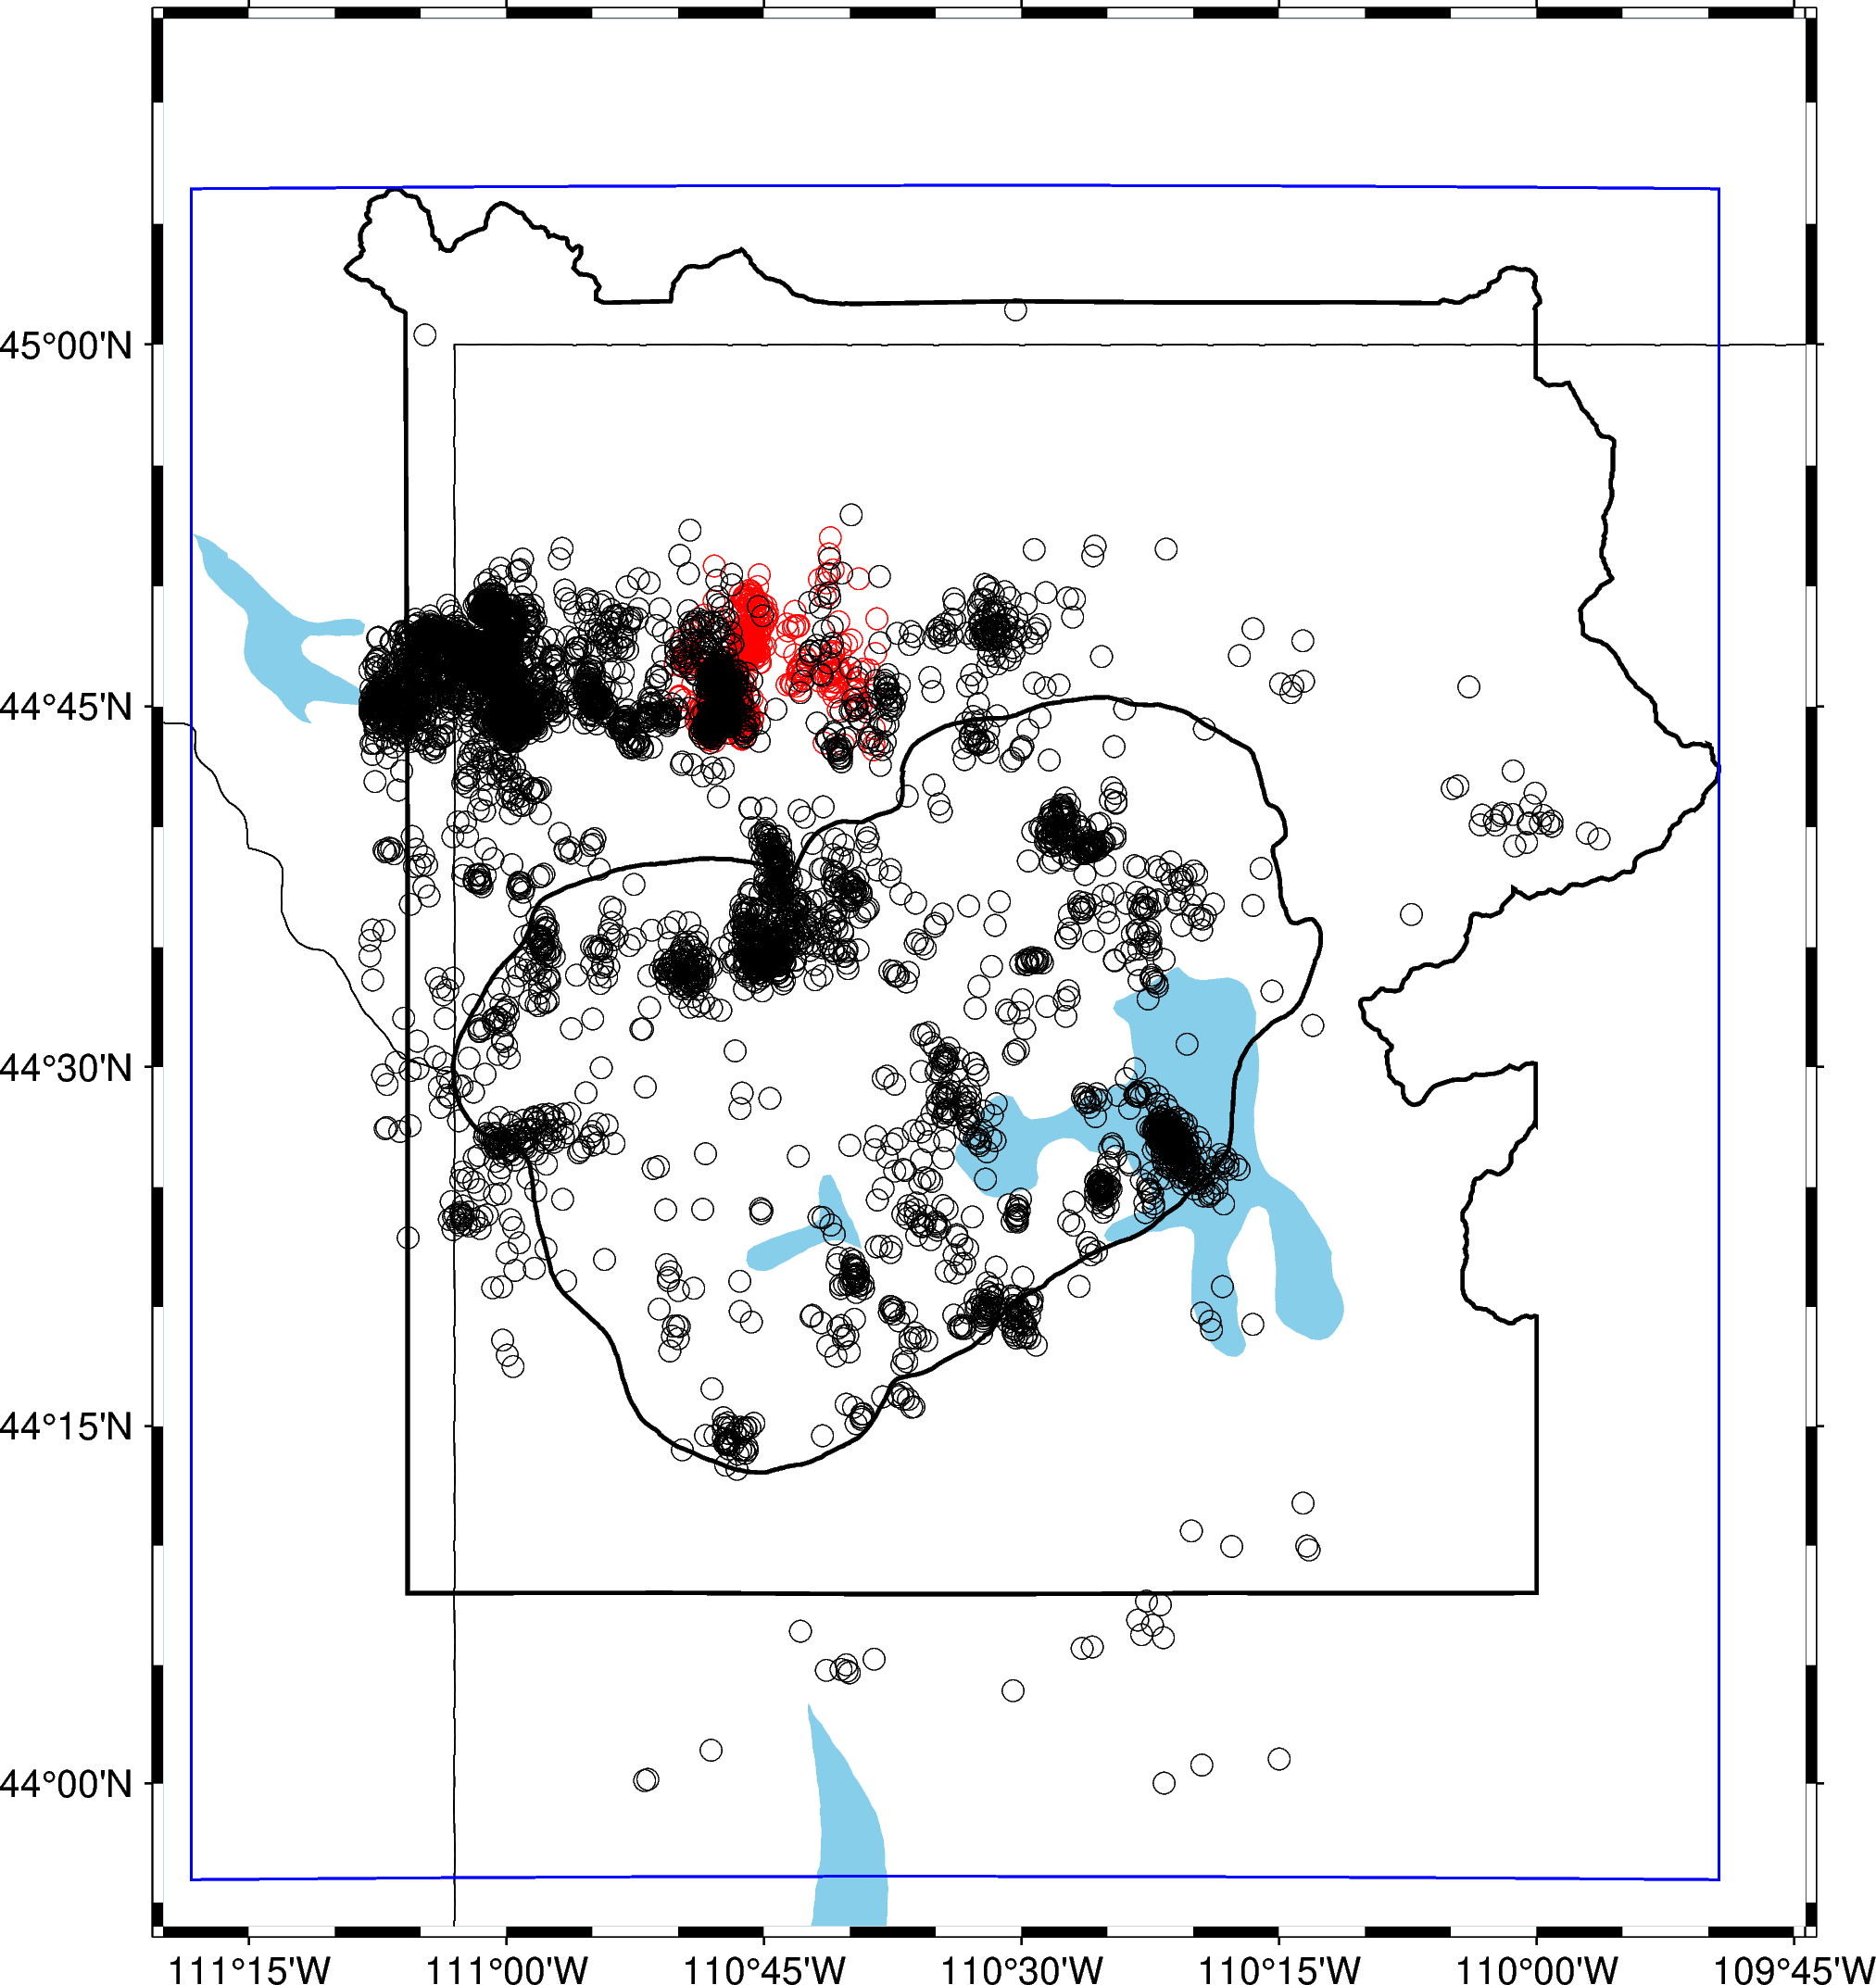

In [8]:
#Draw event map 
region = [
    eq_locs_df.event_lon.min() - 0.2,
    eq_locs_df.event_lon.max() + 0.2,
    eq_locs_df.event_lat.min() - 0.1,
    eq_locs_df.event_lat.max() + 0.2,
]

unique_locations = df_ngb_removed[["source_longitude", "source_latitude"]].drop_duplicates()
unique_ngb_locations = df_ngb[["source_longitude", "source_latitude"]].drop_duplicates()

fig = pygmt.Figure()
fig.basemap(region=region, projection="M15c", frame=True)
fig.coast(land="white", borders=2, water="skyblue")
fig.plot(data=ys_border, pen="1.0p,black")
fig.plot(data=caldera, pen='1.0p,black')
fig.plot(x=unique_ngb_locations.source_longitude, y=unique_ngb_locations.source_latitude, style="c0.2c", pen="0.2p,red")
fig.plot(x=unique_locations.source_longitude, y=unique_locations.source_latitude, style="c0.2c", pen="0.2p,black")
fig.plot(ys_bb, pen="0.6p,blue")
fig.show()

In [9]:
# Keep stations with more than 200 observations
stat_counts = df_original.value_counts("station").to_frame().reset_index()
stat_counts.columns = ["Station", "Count"]
df_org_filtcounts = df_ngb_removed[np.isin(df_ngb_removed.station, stat_counts[stat_counts.Count >= 200])]

In [10]:
stat_counts

,Station,Count
0,YNR,2238
1,YMR,1596
2,YMC,1463
3,YHB,1169
4,YHH,1097
5,YFT,929
6,YUF,915
7,YHL,582
8,YML,528
9,YTP,476


## Feature selection?

In [11]:
# Make train and test datasets

test_size = 0.2
station = "YNR"

station_df = df_org_filtcounts[df_org_filtcounts.station == station]

evids = np.unique(df_org_filtcounts.event_identifier)
train_evids, test_evids = train_test_split(evids, test_size = test_size, random_state = 843823)

train_inds = np.isin(station_df.event_identifier, train_evids)
train_df = station_df[train_inds]
test_df = station_df[~train_inds]

# assert len(train_df.event_identifier.unique()) == len(train_evids)
# assert len(test_df.event_identifier.unique()) == len(test_evids)
assert len(test_df) + len(train_df) == len(station_df)

In [12]:
df_org_filtcounts.source_receiver_back_azimuth

0         79.885217
1        141.914754
2        317.579447
3        262.065224
4        310.504241
            ...    
14147     42.664489
14148     70.900113
14149    124.067453
14150    231.711248
14151    290.611070
Name: source_receiver_back_azimuth, Length: 11850, dtype: float64

In [13]:
# Computes the feature matrix from a dataframe
def compute_feature_matrix(df, scaler = True):
    # Loosely speaking empirical magnitudes look like:
    # M = log10(A) + Q(Delta) 
    # where A is the amplitude and Q a distance dependent correction term.
    # Additionally, the difference between log10 and log amounts to a scalar
    # that a machine can learn.
    # Basically, I'm interested in features that:
    #   (1) Measure size in, potentially, different amplitudes.
    # different `passbands' deviates from the noise, 
    n_rows = len(df)
    n_columns = 34
    X = np.zeros([n_rows, n_columns])
    # Get a proxy on size
    w1 = 0.5
    w2 = 1 - w1
    # These are effectively amplitude ratios.  Note,
    # log(a/b) = log(a) - log(b)
    X[:,0]  = w1*(np.log(df['radial_avg_signal_1.00']) - np.log(df['radial_avg_noise_1.00'])) \
            + w2*(np.log(df['transverse_avg_signal_1.00']) - np.log(df['transverse_avg_noise_1.00']))
    X[:,1]  = w1*(np.log(df['radial_avg_signal_2.00']) - np.log(df['radial_avg_noise_2.00'])) \
            + w2*(np.log(df['transverse_avg_signal_2.00']) - np.log(df['transverse_avg_noise_2.00']))
    X[:,2]  = w1*(np.log(df['radial_avg_signal_3.00']) - np.log(df['radial_avg_noise_3.00'])) \
            + w2*(np.log(df['transverse_avg_signal_3.00']) - np.log(df['transverse_avg_noise_3.00']))
    X[:,3]  = w1*(np.log(df['radial_avg_signal_4.00']) - np.log(df['radial_avg_noise_4.00'])) \
            + w2*(np.log(df['transverse_avg_signal_4.00']) - np.log(df['transverse_avg_noise_4.00']))
    X[:,4]  = w1*(np.log(df['radial_avg_signal_5.00']) - np.log(df['radial_avg_noise_5.00'])) \
            + w2*(np.log(df['transverse_avg_signal_5.00']) - np.log(df['transverse_avg_noise_5.00']))
    X[:,5]  = w1*(np.log(df['radial_avg_signal_6.00']) - np.log(df['radial_avg_noise_6.00'])) \
            + w2*(np.log(df['transverse_avg_signal_6.00']) - np.log(df['transverse_avg_noise_6.00']))
    X[:,6]  = w1*(np.log(df['radial_avg_signal_7.00']) - np.log(df['radial_avg_noise_7.00'])) \
            + w2*(np.log(df['transverse_avg_signal_7.00']) - np.log(df['transverse_avg_noise_7.00']))
    X[:,7]  = w1*(np.log(df['radial_avg_signal_8.00']) - np.log(df['radial_avg_noise_8.00'])) \
            + w2*(np.log(df['transverse_avg_signal_8.00']) - np.log(df['transverse_avg_noise_8.00']))
    X[:,8]  = w1*(np.log(df['radial_avg_signal_9.00']) - np.log(df['radial_avg_noise_9.00'])) \
            + w2*(np.log(df['transverse_avg_signal_9.00']) - np.log(df['transverse_avg_noise_9.00']))
    X[:,9]  = w1*(np.log(df['radial_avg_signal_10.00']) - np.log(df['radial_avg_noise_10.00'])) \
            + w2*(np.log(df['transverse_avg_signal_10.00']) - np.log(df['transverse_avg_noise_10.00']))
    X[:,10]  = w1*(np.log(df['radial_avg_signal_11.00']) - np.log(df['radial_avg_noise_11.00'])) \
             + w2*(np.log(df['transverse_avg_signal_11.00']) - np.log(df['transverse_avg_noise_11.00']))
    X[:,11]  = w1*(np.log(df['radial_avg_signal_12.00']) - np.log(df['radial_avg_noise_12.00'])) \
             + w2*(np.log(df['transverse_avg_signal_12.00']) - np.log(df['transverse_avg_noise_12.00']))
    
    # Look at amplitudes
    X[:,12] = w1*np.log(df['radial_avg_signal_1.00']) + w2*np.log(df['transverse_avg_signal_1.00']) 
    X[:,13] = w1*np.log(df['radial_avg_signal_2.00']) + w2*np.log(df['transverse_avg_signal_2.00']) 
    X[:,14] = w1*np.log(df['radial_avg_signal_3.00']) + w2*np.log(df['transverse_avg_signal_3.00']) 
    X[:,15] = w1*np.log(df['radial_avg_signal_4.00']) + w2*np.log(df['transverse_avg_signal_4.00']) 
    X[:,16] = w1*np.log(df['radial_avg_signal_5.00']) + w2*np.log(df['transverse_avg_signal_5.00']) 
    X[:,17] = w1*np.log(df['radial_avg_signal_6.00']) + w2*np.log(df['transverse_avg_signal_6.00']) 
    X[:,18] = w1*np.log(df['radial_avg_signal_7.00']) + w2*np.log(df['transverse_avg_signal_7.00']) 
    X[:,19] = w1*np.log(df['radial_avg_signal_8.00']) + w2*np.log(df['transverse_avg_signal_8.00']) 
    X[:,20] = w1*np.log(df['radial_avg_signal_9.00']) + w2*np.log(df['transverse_avg_signal_9.00']) 
    X[:,21] = w1*np.log(df['radial_avg_signal_10.00']) + w2*np.log(df['transverse_avg_signal_10.00']) 
    X[:,22] = w1*np.log(df['radial_avg_signal_11.00']) + w2*np.log(df['transverse_avg_signal_11.00'])
    X[:,23] = w1*np.log(df['radial_avg_signal_12.00']) + w2*np.log(df['transverse_avg_signal_12.00']) 

 
    # Frequency and max amplitude
    X[:,24] = w1*np.log(df['radial_signal_dominant_frequency']) \
            + w2*np.log(df['transverse_signal_dominant_frequency'])
    X[:,25] = w1*np.log(df['radial_signal_dominant_amplitude']) \
            + w2*np.log(df['transverse_signal_dominant_amplitude'])
    # Time-based featuers: Look at max amplitudes of noise/signal
    X[:,26] = w1*(np.log(df['radial_noise_maximum_value'] - df['radial_noise_minimum_value'])) \
            + w2*(np.log(df['transverse_noise_maximum_value'] - df['transverse_noise_minimum_value']))
    X[:,27] = w1*(np.log(df['radial_signal_maximum_value'] - df['radial_signal_minimum_value'])) \
            + w2*(np.log(df['transverse_signal_maximum_value'] - df['transverse_signal_minimum_value']))
    X[:,28] = w1*np.log(df['radial_signal_variance']) + w2*np.log(df['transverse_signal_variance'])
    X[:,29] = w1*np.log(df['radial_noise_variance']) + w2*np.log(df['transverse_noise_variance'])
    # Source/recv distance (take log to flatten this)
    X[:,30] = np.log(df['source_receiver_distance_km'])
    X[:,31] = df['source_depth_km']
    # Caution - not a great features for linear methods b/c 359 and 361 are similar
    X[:, 32] = np.sin(df['source_receiver_back_azimuth']*np.pi/180)
    X[:,33] = df['source_receiver_back_azimuth']

    # Standardize features
    if (scaler):
        scaler = StandardScaler()
        scaler = scaler.fit(X)
        X = scaler.transform(X)
        return X, scaler
    
    return X

In [14]:
train_feat_matrix_scaled, scaler = compute_feature_matrix(train_df)
train_feat_matrix_unscaled = compute_feature_matrix(train_df, scaler=False)

train_y = train_df.magnitude.values

In [15]:
train_feat_matrix_scaled[0], train_feat_matrix_unscaled[0]

(array([ 1.88906436, -1.90151351, -1.81062027, -1.38322338,  0.0208138 ,
         0.44268515,  0.88238317,  1.43368   ,  1.74858432,  1.65394177,
         1.47599797,  1.38646178,  1.31970081,  0.47288014,  0.24091939,
         0.21027478,  0.54284039,  0.68136226,  0.75238851,  0.76320705,
         0.7003001 ,  0.6161483 ,  0.53095421,  0.45296251, -0.26660289,
         0.63221295,  0.2710748 ,  0.44285374,  0.46454922,  0.40821716,
         1.5532536 ,  2.12487856,  0.26015244, -0.70619211]),
 array([ 2.47501973e+00,  9.81585002e-01,  1.17985174e+00,  1.60884355e+00,
         2.41149359e+00,  2.65637858e+00,  2.84836248e+00,  3.02347827e+00,
         3.04096522e+00,  2.87389887e+00,  2.69625754e+00,  2.57597257e+00,
        -1.09126797e+00, -9.03146105e-01, -8.05566516e-01, -8.24877970e-01,
        -3.50565235e-01, -1.25133046e-01, -2.38990207e-02, -2.00271192e-02,
        -1.04216681e-01, -2.08210099e-01, -3.20828569e-01, -4.45309339e-01,
         2.01267585e+00, -1.82514717e+00,  9

In [16]:
train_y

array([2.52, 2.  , 1.76, ..., 1.92, 1.63, 1.79])

In [17]:
for col in df_org_filtcounts.columns:
    print(col)

arrival_identifier
channel1
channel2
event_identifier
location_code
magnitude
magnitude_type
network
radial_avg_noise_1.00
radial_avg_noise_10.00
radial_avg_noise_11.00
radial_avg_noise_12.00
radial_avg_noise_13.00
radial_avg_noise_14.00
radial_avg_noise_15.00
radial_avg_noise_16.00
radial_avg_noise_17.00
radial_avg_noise_18.00
radial_avg_noise_2.00
radial_avg_noise_3.00
radial_avg_noise_4.00
radial_avg_noise_5.00
radial_avg_noise_6.00
radial_avg_noise_7.00
radial_avg_noise_8.00
radial_avg_noise_9.00
radial_avg_signal_1.00
radial_avg_signal_10.00
radial_avg_signal_11.00
radial_avg_signal_12.00
radial_avg_signal_13.00
radial_avg_signal_14.00
radial_avg_signal_15.00
radial_avg_signal_16.00
radial_avg_signal_17.00
radial_avg_signal_18.00
radial_avg_signal_2.00
radial_avg_signal_3.00
radial_avg_signal_4.00
radial_avg_signal_5.00
radial_avg_signal_6.00
radial_avg_signal_7.00
radial_avg_signal_8.00
radial_avg_signal_9.00
radial_noise_dominant_amplitude
radial_noise_dominant_frequency
radial_

In [18]:
columns = ["amp_ratio_01.0", "amp_ratio_02.0", "amp_ratio_03.0", "amp_ratio_04.0", 
             "amp_ratio_05.0", "amp_ratio_06.0", "amp_ratio_07.0", "amp_ratio_08.0",
             "amp_ratio_09.0", "amp_ratio_10.0", "amp_ratio_11.0", "amp_ratio_12.0", 
             "amp_01.0", "amp_02.0", "amp_03.0", "amp_04.0", 
             "amp_05.0", "amp_06.0", "amp_07.0", "amp_08.0",
             "amp_09.0", "amp_10.0", "amp_11.0", "amp_12.0", 
             "signal_dominant_frequency", "signal_dominant_amplitude", 
             "noise_max_amplitude", "signal_max_amplitude", "signal_variance", "noise_variance",
             "source_receiver_distance_logkm", "source_depth_km", "sin_receiver_back_azimuth", 
             "receiver_back_azimuth"]
train_feat_df = pd.DataFrame(train_feat_matrix_scaled, columns=columns)

In [19]:
train_feat_df_unscaled = pd.DataFrame(train_feat_matrix_unscaled, columns=columns)

In [20]:
feat_target_df = train_feat_df.copy()
feat_target_df.loc[:, "magnitude"] = train_y
corr = feat_target_df.corr()
corr.style.background_gradient(cmap="coolwarm")

,amp_ratio_01.0,amp_ratio_02.0,amp_ratio_03.0,amp_ratio_04.0,amp_ratio_05.0,amp_ratio_06.0,amp_ratio_07.0,amp_ratio_08.0,amp_ratio_09.0,amp_ratio_10.0,amp_ratio_11.0,amp_ratio_12.0,amp_01.0,amp_02.0,amp_03.0,amp_04.0,amp_05.0,amp_06.0,amp_07.0,amp_08.0,amp_09.0,amp_10.0,amp_11.0,amp_12.0,signal_dominant_frequency,signal_dominant_amplitude,noise_max_amplitude,signal_max_amplitude,signal_variance,noise_variance,source_receiver_distance_logkm,source_depth_km,sin_receiver_back_azimuth,receiver_back_azimuth,magnitude
amp_ratio_01.0,1.000000,0.462298,0.313222,0.346413,0.332033,0.274152,0.210694,0.165184,0.127259,0.089993,0.058132,0.037057,0.567595,0.494897,0.473982,0.476164,0.478248,0.474543,0.470882,0.470696,0.470182,0.468759,0.467833,0.466957,-0.070956,0.449648,0.425518,0.450598,0.468533,0.424565,-0.212464,-0.151262,0.139033,-0.103983,0.349092
amp_ratio_02.0,0.462298,1.000000,0.753866,0.706842,0.649102,0.588459,0.523903,0.471215,0.423686,0.373860,0.320727,0.273326,0.346037,0.424087,0.411416,0.408538,0.407439,0.403526,0.399722,0.398607,0.400066,0.402519,0.405072,0.406830,-0.023910,0.395487,0.294239,0.402609,0.411194,0.289626,-0.425505,-0.184800,0.233778,-0.171372,0.161249
amp_ratio_03.0,0.313222,0.753866,1.000000,0.862224,0.733553,0.674654,0.614023,0.557766,0.506106,0.453302,0.395007,0.339893,0.270144,0.325561,0.367644,0.352865,0.342863,0.346211,0.347022,0.346965,0.348863,0.352131,0.355478,0.358024,0.000174,0.355997,0.230406,0.367196,0.361491,0.223184,-0.492988,-0.207890,0.218886,-0.159280,0.070657
amp_ratio_04.0,0.346413,0.706842,0.862224,1.000000,0.906820,0.786451,0.678581,0.597143,0.532287,0.473222,0.413877,0.362836,0.328380,0.360412,0.389463,0.407491,0.403793,0.398512,0.393530,0.390194,0.389410,0.390440,0.391896,0.392921,-0.032428,0.391261,0.255357,0.398842,0.398540,0.248542,-0.472056,-0.230499,0.205679,-0.155427,0.114002
amp_ratio_05.0,0.332033,0.649102,0.733553,0.906820,1.000000,0.921138,0.788202,0.689027,0.610978,0.542418,0.480792,0.432370,0.281966,0.309684,0.324917,0.347391,0.367389,0.367739,0.357989,0.348659,0.342826,0.339998,0.338815,0.338140,-0.039327,0.342903,0.177338,0.347574,0.347046,0.173937,-0.389022,-0.150450,0.150867,-0.110761,0.089017
amp_ratio_06.0,0.274152,0.588459,0.674654,0.786451,0.921138,1.000000,0.943094,0.850870,0.761696,0.678934,0.604723,0.545409,0.210990,0.236995,0.253608,0.268490,0.293667,0.313379,0.312501,0.300928,0.289232,0.281441,0.277532,0.275693,-0.022928,0.296800,0.085514,0.300041,0.288634,0.084863,-0.298309,-0.043125,0.058622,-0.036911,0.062217
amp_ratio_07.0,0.210694,0.523903,0.614023,0.678581,0.788202,0.943094,1.000000,0.962257,0.880945,0.788319,0.699327,0.625933,0.146500,0.172907,0.191304,0.200771,0.222913,0.252732,0.263043,0.255216,0.241938,0.231769,0.226471,0.224220,0.018437,0.252703,0.018937,0.255844,0.236859,0.019008,-0.228734,0.028878,-0.005308,0.011407,0.041256
amp_ratio_08.0,0.165184,0.471215,0.557766,0.597143,0.689027,0.850870,0.962257,1.000000,0.966288,0.886795,0.791521,0.705848,0.100006,0.127526,0.141693,0.148433,0.167845,0.199037,0.216302,0.216797,0.208678,0.200506,0.195499,0.192993,0.072313,0.219656,-0.022590,0.223092,0.200032,-0.023497,-0.197162,0.067037,-0.004258,-0.002663,0.022257
amp_ratio_09.0,0.127259,0.423686,0.506106,0.532287,0.610978,0.761696,0.880945,0.966288,1.000000,0.967953,0.890486,0.803303,0.063256,0.091793,0.102142,0.107754,0.124577,0.153841,0.173645,0.180796,0.180063,0.176726,0.173611,0.171304,0.113181,0.193584,-0.054786,0.196775,0.170948,-0.057233,-0.169146,0.094151,0.010541,-0.022455,0.009638
amp_ratio_10.0,0.089993,0.373860,0.453302,0.473222,0.542418,0.678934,0.788319,0.886795,0.967953,1.000000,0.970480,0.904660,0.031566,0.060970,0.069211,0.074615,0.088984,0.114746,0.133610,0.143051,0.147269,0.149302,0.149584,0.148604,0.131853,0.165362,-0.086712,0.167810,0.141595,-0.090998,-0.120932,0.127975,0.008506,-0.022901,0.006566


In [23]:
from sklearn.feature_selection import mutual_info_regression, SequentialFeatureSelector, RFE

In [24]:
mutual_reg = mutual_info_regression(train_feat_matrix_scaled, train_y, random_state=843824)
mutual_reg

array([0.08908005, 0.03825143, 0.033777  , 0.02070277, 0.        ,
       0.02458994, 0.00224099, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.60486427, 0.66553649, 0.70023851,
       0.68061486, 0.69832226, 0.69226863, 0.72709206, 0.65674533,
       0.63718969, 0.5976978 , 0.59772919, 0.58795674, 0.05380217,
       0.57398303, 0.5048397 , 0.56000021, 0.6658008 , 0.56528274,
       0.0884263 , 0.05462494, 0.05467117, 0.0805245 ])

In [25]:
train_feat_df.columns[np.argsort(mutual_reg, axis=0)]

Index(['amp_ratio_05.0', 'amp_ratio_08.0', 'amp_ratio_09.0', 'amp_ratio_10.0',
       'amp_ratio_11.0', 'amp_ratio_12.0', 'amp_ratio_07.0', 'amp_ratio_04.0',
       'amp_ratio_06.0', 'amp_ratio_03.0', 'amp_ratio_02.0',
       'signal_dominant_frequency', 'source_depth_km',
       'sin_receiver_back_azimuth', 'receiver_back_azimuth',
       'source_receiver_distance_logkm', 'amp_ratio_01.0',
       'noise_max_amplitude', 'signal_max_amplitude', 'noise_variance',
       'signal_dominant_amplitude', 'amp_12.0', 'amp_10.0', 'amp_11.0',
       'amp_01.0', 'amp_09.0', 'amp_08.0', 'amp_02.0', 'signal_variance',
       'amp_04.0', 'amp_06.0', 'amp_05.0', 'amp_03.0', 'amp_07.0'],
      dtype='object')

In [26]:
# Make cross validation splits across evids

from sklearn.model_selection import KFold
evids = train_df.event_identifier.unique()
kf = KFold(n_splits=5, shuffle=True, random_state=843824)
folds = []
for train_index, test_index in kf.split(evids):
    # Get the evids corresponding to the split indicies
    fold_train_evids = evids[train_index]
    fold_test_evids = evids[test_index]
    # Get rows of training dataset that correspond to split evids
    fold_train_inds = np.where(np.isin(train_df.event_identifier, fold_train_evids))[0]
    fold_test_inds = np.where(np.isin(train_df.event_identifier, fold_test_evids))[0]
    
    folds.append((fold_train_inds, fold_test_inds))

In [27]:
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.metrics import r2_score

## RFE

from RFECV, know that most of the gain comes from 5-10 features. Use RFE to find 8 "best" features

In [28]:
# CV performace with these all features in linear model
svr = SVR(C=1.0, epsilon=0.1, kernel="linear")
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
cross_validate(pipeline, train_feat_matrix_unscaled[:, :-1], train_y, cv=folds, scoring="r2")

{'fit_time': array([0.64018965, 0.61431837, 0.53480005, 0.5501256 , 0.56039119]),
 'score_time': array([0.00518036, 0.00512862, 0.00528097, 0.00456119, 0.00487518]),
 'test_score': array([0.86956751, 0.89875385, 0.86411666, 0.81567312, 0.88843371])}

In [29]:
train_feat_df.columns[:-1]

Index(['amp_ratio_01.0', 'amp_ratio_02.0', 'amp_ratio_03.0', 'amp_ratio_04.0',
       'amp_ratio_05.0', 'amp_ratio_06.0', 'amp_ratio_07.0', 'amp_ratio_08.0',
       'amp_ratio_09.0', 'amp_ratio_10.0', 'amp_ratio_11.0', 'amp_ratio_12.0',
       'amp_01.0', 'amp_02.0', 'amp_03.0', 'amp_04.0', 'amp_05.0', 'amp_06.0',
       'amp_07.0', 'amp_08.0', 'amp_09.0', 'amp_10.0', 'amp_11.0', 'amp_12.0',
       'signal_dominant_frequency', 'signal_dominant_amplitude',
       'noise_max_amplitude', 'signal_max_amplitude', 'signal_variance',
       'noise_variance', 'source_receiver_distance_logkm', 'source_depth_km',
       'sin_receiver_back_azimuth'],
      dtype='object')

In [30]:
# Find best features for whole training dataset
estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=8, step=1)
selector = selector.fit(train_feat_matrix_scaled[:, :-1], train_y)

train_feat_df.columns[:-1][selector.support_]

Index(['amp_ratio_08.0', 'amp_ratio_09.0', 'amp_ratio_10.0', 'amp_ratio_11.0',
       'amp_02.0', 'amp_03.0', 'noise_variance',
       'source_receiver_distance_logkm'],
      dtype='object')

In [31]:
# Sort features by importance - first 8 are in no particular order
train_feat_df.columns[:-1][np.argsort(selector.ranking_)]

Index(['source_receiver_distance_logkm', 'noise_variance', 'amp_ratio_08.0',
       'amp_ratio_09.0', 'amp_ratio_10.0', 'amp_ratio_11.0', 'amp_02.0',
       'amp_03.0', 'amp_07.0', 'amp_05.0', 'amp_09.0',
       'signal_dominant_amplitude', 'signal_variance', 'amp_10.0', 'amp_12.0',
       'sin_receiver_back_azimuth', 'amp_01.0', 'amp_ratio_12.0', 'amp_04.0',
       'amp_08.0', 'amp_06.0', 'amp_ratio_01.0', 'amp_11.0', 'source_depth_km',
       'amp_ratio_07.0', 'signal_max_amplitude', 'amp_ratio_06.0',
       'noise_max_amplitude', 'amp_ratio_03.0', 'signal_dominant_frequency',
       'amp_ratio_02.0', 'amp_ratio_05.0', 'amp_ratio_04.0'],
      dtype='object')

In [32]:
# Training performace with these 8 features in the linear model 
r2_score(selector.predict(train_feat_matrix_scaled[:, :-1]), train_y)

0.8500775294022314

In [33]:
# CV performace with these 8 features in non-linear model
svr = SVR(C=1.0, epsilon=0.2)
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
cross_validate(pipeline, train_feat_matrix_unscaled[:, :-1][:, selector.support_], train_y, cv=folds, scoring="r2")

{'fit_time': array([0.02880621, 0.02964854, 0.02901506, 0.02789211, 0.02789211]),
 'score_time': array([0.00426054, 0.00416803, 0.00393605, 0.00366759, 0.00370097]),
 'test_score': array([0.91588355, 0.89247004, 0.82311334, 0.8814579 , 0.87640051])}

In [34]:
# Get best RFE features for various folds and evaluate 
for fold in folds:
    # Pipeline for choosing features for fold
    estimator = SVR(kernel="linear")
    selector = RFE(estimator, n_features_to_select=8, step=1)
    pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('selector', selector)])
    
    # Fold data - exclude receiver_back_azimuth since linear model
    cv_train_X = train_feat_matrix_unscaled[fold[0], :-1]
    cv_train_y = train_y[fold[0]]
    cv_test_X = train_feat_matrix_unscaled[fold[1], :-1]
    cv_test_y = train_y[fold[1]]
    
    # Fit selector to fold training data
    s = pipeline.fit(cv_train_X, cv_train_y)
    # Make predictions on the fold test data
    preds = s.predict(cv_test_X)
    # Get the features for this model
    support = s.named_steps.selector.support_
    # Print the features
    print(train_feat_df.columns[:-1][support])
    # Print the test R^2 score
    print("Linear performance:", r2_score(cv_test_y, preds))
    
    # Use this features in a non-linear model. Cross validate over all the folds
    svr = SVR(C=1.0, epsilon=0.2)
    nl_pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
    rbf_cv = cross_validate(nl_pipeline, train_feat_matrix_unscaled[:, :-1][:, support],
                         train_y, cv=folds, scoring="r2")["test_score"]
    print(rbf_cv)
    print(np.mean(rbf_cv))

Index(['amp_02.0', 'amp_03.0', 'amp_05.0', 'amp_07.0', 'amp_10.0', 'amp_12.0',
       'noise_variance', 'source_receiver_distance_logkm'],
      dtype='object')
Linear performance: 0.8693315701597428
[0.92915959 0.90078436 0.83537976 0.88885402 0.8831811 ]
0.8874717662158093
Index(['amp_02.0', 'amp_03.0', 'amp_06.0', 'amp_07.0', 'amp_09.0', 'amp_10.0',
       'noise_variance', 'source_receiver_distance_logkm'],
      dtype='object')
Linear performance: 0.8931223648079745
[0.92886957 0.90180091 0.83730728 0.88947296 0.88320128]
0.8881304007215425
Index(['amp_02.0', 'amp_04.0', 'amp_05.0', 'amp_06.0',
       'signal_dominant_amplitude', 'signal_variance', 'noise_variance',
       'source_receiver_distance_logkm'],
      dtype='object')
Linear performance: 0.8438894361004609
[0.92805782 0.90162488 0.83331027 0.88785051 0.88414018]
0.8869967339429052
Index(['amp_02.0', 'amp_04.0', 'amp_05.0', 'amp_06.0',
       'signal_dominant_amplitude', 'signal_variance', 'noise_variance',
       'sourc

## Sequential Feature Selection. 
Forward selection until change in score is less than 1e-4 or reach half of the features. Slightly better CV performace with 13 features than 46 for non-linear SVR. Pretty comparable performace between the 13 and 46 features in linear SVR. 

In [35]:
no_sin_ba_feat_inds = np.delete(np.arange(train_feat_matrix_unscaled.shape[1]), -2)

In [36]:
train_feat_df.columns[no_sin_ba_feat_inds]

Index(['amp_ratio_01.0', 'amp_ratio_02.0', 'amp_ratio_03.0', 'amp_ratio_04.0',
       'amp_ratio_05.0', 'amp_ratio_06.0', 'amp_ratio_07.0', 'amp_ratio_08.0',
       'amp_ratio_09.0', 'amp_ratio_10.0', 'amp_ratio_11.0', 'amp_ratio_12.0',
       'amp_01.0', 'amp_02.0', 'amp_03.0', 'amp_04.0', 'amp_05.0', 'amp_06.0',
       'amp_07.0', 'amp_08.0', 'amp_09.0', 'amp_10.0', 'amp_11.0', 'amp_12.0',
       'signal_dominant_frequency', 'signal_dominant_amplitude',
       'noise_max_amplitude', 'signal_max_amplitude', 'signal_variance',
       'noise_variance', 'source_receiver_distance_logkm', 'source_depth_km',
       'receiver_back_azimuth'],
      dtype='object')

In [37]:
svr = SVR(C=1.0, epsilon=0.2)
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
sfs = SequentialFeatureSelector(pipeline, n_features_to_select="auto", tol=1e-3, scoring="r2", 
                                cv=folds, n_jobs=3).fit(train_feat_matrix_unscaled[:,no_sin_ba_feat_inds], train_y)

sfs.get_feature_names_out(train_feat_df.columns[no_sin_ba_feat_inds])

array(['amp_02.0', 'amp_09.0', 'noise_variance',
       'source_receiver_distance_logkm', 'receiver_back_azimuth'],
      dtype=object)

In [38]:
svr = SVR(C=1.0, epsilon=0.2)
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
cross_validate(pipeline, train_feat_matrix_unscaled[:,no_sin_ba_feat_inds][:, sfs.get_support()], train_y, cv=folds)

{'fit_time': array([0.02663589, 0.02158141, 0.02309513, 0.02341843, 0.01769328]),
 'score_time': array([0.00295782, 0.00292253, 0.00267148, 0.00254154, 0.00241017]),
 'test_score': array([0.92804549, 0.91520941, 0.86539559, 0.90443912, 0.91245423])}

In [39]:
svr = SVR(C=1.0, epsilon=0.2)
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
sfs = SequentialFeatureSelector(pipeline, n_features_to_select="auto", tol=1e-4, scoring="r2", 
                                cv=folds, n_jobs=3).fit(train_feat_matrix_unscaled[:,no_sin_ba_feat_inds], train_y)

sfs.get_feature_names_out(train_feat_df.columns[no_sin_ba_feat_inds])

array(['amp_02.0', 'amp_03.0', 'amp_08.0', 'amp_09.0', 'amp_10.0',
       'noise_variance', 'source_receiver_distance_logkm',
       'receiver_back_azimuth'], dtype=object)

In [40]:
svr = SVR(C=1.0, epsilon=0.2)
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
cross_validate(pipeline, train_feat_matrix_unscaled[:,no_sin_ba_feat_inds][:, sfs.get_support()], train_y, cv=folds)

{'fit_time': array([0.02315903, 0.02360439, 0.0228703 , 0.02469277, 0.02222538]),
 'score_time': array([0.00343156, 0.00303102, 0.00293946, 0.00347209, 0.00315404]),
 'test_score': array([0.92937263, 0.91839011, 0.86670063, 0.90595791, 0.91166273])}

In [41]:
# Performance when using all features
svr = SVR(C=1.0, epsilon=0.2)
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
cross_validate(pipeline, train_feat_matrix_unscaled[:, no_sin_ba_feat_inds], train_y, cv=folds)

{'fit_time': array([0.03388643, 0.03058219, 0.02965832, 0.0285902 , 0.02723002]),
 'score_time': array([0.00503063, 0.00468302, 0.00510168, 0.00444841, 0.00438404]),
 'test_score': array([0.89813359, 0.89766639, 0.84512118, 0.8777472 , 0.88787359])}

## Sequential Feature Selection Linear

In [42]:
svr = SVR(C=1.0, epsilon=0.2, kernel="linear")
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
sfs = SequentialFeatureSelector(pipeline, n_features_to_select="auto", tol=1e-3, scoring="r2", 
                                cv=folds, n_jobs=3).fit(train_feat_matrix_unscaled[:,:-1], train_y)

sfs.get_feature_names_out(train_feat_df.columns[:-1])

array(['amp_ratio_02.0', 'amp_02.0', 'signal_variance',
       'source_receiver_distance_logkm', 'sin_receiver_back_azimuth'],
      dtype=object)

In [43]:
svr = SVR(C=1.0, epsilon=0.2, kernel="linear")
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
all_feats_rbf_cv = cross_validate(pipeline, train_feat_matrix_unscaled[:,no_sin_ba_feat_inds][:, sfs.get_support()], train_y, cv=folds)
print(all_feats_rbf_cv["test_score"])
print(np.mean(all_feats_rbf_cv['test_score']))

[0.86519068 0.89904199 0.86959474 0.83100617 0.88066068]
0.8690988534505193


# Go more in-depth into the effect of the more important features

In [80]:
selected_features_sr = ['amp_02.0', 'amp_04.0', 'amp_07.0', 'amp_10.0', 'amp_ratio_01.0',
                       'signal_dominant_amplitude', 'signal_variance', 'noise_variance', 
                       'source_receiver_distance_logkm', 'noise_max_amplitude', 'receiver_back_azimuth', 
                        'source_depth_km', 'signal_max_amplitude']

fewer_features_sr = ['amp_02.0','signal_max_amplitude', 'signal_variance', 'noise_variance', 
                       'source_receiver_distance_logkm', 'noise_max_amplitude', 'receiver_back_azimuth', 
                     'source_depth_km']

In [81]:
def svr_cv(X, y, folds, kernel="rbf", C=1.0, epsilon=0.2, degree=3):
    svr = SVR(C=C, epsilon=epsilon, kernel=kernel, degree=degree)
    pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
    cv_scores = cross_validate(pipeline, X, y, scoring="r2", cv=folds)["test_score"]
    
    return cv_scores

In [82]:
def seq_feature_importance(selected_features, train_feat_df_unscaled, starting_features=None, kernel="rbf"):
    feat_selection = np.copy(selected_features)
    r2_maxs = []
    r2_mins = []
    r2_means = []
    
    best_features = []
    
    plot_start_ind = 1
    if starting_features is not None:
        best_features = starting_features
        train_X = train_feat_df_unscaled[best_features].values
        cv_scores = svr_cv(train_X, train_y, folds, kernel=kernel)
        mean_cv = np.mean(cv_scores)
        print(best_features, mean_cv)
        r2_means.append(mean_cv)
        r2_mins.append(mean_cv)
        r2_maxs.append(mean_cv)
        plot_start_ind = 0

    for it in range(len(selected_features)):
        print("iteration", it)
        print(best_features)

        it_r2_vals = []
    #     best_feat_ind = -1

        for feature_ind in range(len(feat_selection)):
            features = [feat_selection[feature_ind]]
            if len(best_features) == 0:
                train_X = train_feat_df_unscaled[features].values.reshape(-1, 1)
            else:
                features = np.concatenate([best_features, features])
                train_X = train_feat_df_unscaled[features].values

            cv_scores = svr_cv(train_X, train_y, folds, kernel=kernel)

            mean_cv = np.mean(cv_scores)
            print(features[-1], mean_cv)
    #         if mean_cv > max_r2:
    #             best_feat_ind = feature_ind
    #             max_r2 = mean_cv

            it_r2_vals.append(mean_cv)

        best_feat_ind = np.argmax(it_r2_vals)
        best_features.append(feat_selection[best_feat_ind])
        r2_means.append(np.mean(it_r2_vals))
        r2_mins.append(np.min(it_r2_vals))
        r2_maxs.append(np.max(it_r2_vals))

        feat_selection = np.delete(feat_selection, best_feat_ind)

    
    n_features = np.arange(plot_start_ind, len(selected_features)+1)
    plt.plot(n_features, r2_means, linestyle="--", color="k", label="mean")
    plt.plot(n_features, r2_mins, color="k", label="min")
    plt.fill_between(n_features, r2_maxs, r2_mins, color="gray")
    plt.plot(n_features, r2_maxs, marker="x", color="r", label="max")
    plt.xticks(n_features) #, labels=n_features[::-1]) #, labels=best_features, rotation=45);
    plt.grid()
    plt.xlabel("N Features") #("N Features to Choose From");
    plt.ylabel(r"Mean $R^2$ of 5-fold CV");
    plt.legend();
    
    return best_features

iteration 0
[]
amp_02.0 0.6935574685766304
amp_04.0 0.6876448900848926
amp_07.0 0.661410075098845
amp_10.0 0.6037089467534107
amp_ratio_01.0 0.11233619066700976
signal_dominant_amplitude 0.6040804983426239
signal_variance 0.6195361266310161
noise_variance 0.5842771992705188
source_receiver_distance_logkm 0.045437305789500025
noise_max_amplitude 0.5619229713516125
receiver_back_azimuth 0.044084072699820245
source_depth_km 0.02048179531664296
signal_max_amplitude 0.5852769053909349
iteration 1
['amp_02.0']
amp_04.0 0.6957693533639047
amp_07.0 0.6923325769818074
amp_10.0 0.6957839272354385
amp_ratio_01.0 0.701077742861534
signal_dominant_amplitude 0.6919756261250593
signal_variance 0.6958642980931463
noise_variance 0.7020099526501686
source_receiver_distance_logkm 0.8687783667024039
noise_max_amplitude 0.7034455741131991
receiver_back_azimuth 0.7753644265525933
source_depth_km 0.7538070668504527
signal_max_amplitude 0.6982223114273447
iteration 2
['amp_02.0', 'source_receiver_distance_log

['amp_02.0',
 'source_receiver_distance_logkm',
 'receiver_back_azimuth',
 'signal_variance',
 'noise_max_amplitude',
 'amp_07.0',
 'amp_10.0',
 'amp_04.0',
 'signal_max_amplitude',
 'signal_dominant_amplitude',
 'noise_variance',
 'source_depth_km',
 'amp_ratio_01.0']

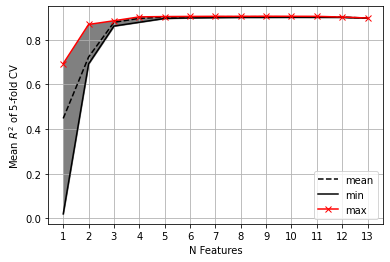

In [83]:
best_features_sr = seq_feature_importance(selected_features_sr, train_feat_df_unscaled)
best_features_sr

In [78]:
# All selected features with sr distance and back azimuth
selected_feat_sr_cv = svr_cv(train_feat_df_unscaled[selected_features_sr], train_y, folds)
print(selected_feat_sr_cv)
print(np.mean(selected_feat_sr_cv))

[0.91988462 0.90711865 0.85764228 0.89947727 0.90602732]
0.8980300270160999


In [79]:
# Top 4 selected features with sr distance and back azimuth
top_feat_sr_cv = svr_cv(train_feat_df_unscaled[best_features_sr[0:4]], train_y, folds)
print(top_feat_sr_cv )
print(np.mean(top_feat_sr_cv))

[0.92517942 0.90649509 0.85636474 0.90723342 0.91817858]
0.9026902505218264


iteration 0
[]
amp_02.0 0.6935574685766304
signal_max_amplitude 0.5852769053909349
signal_variance 0.6195361266310161
noise_variance 0.5842771992705188
source_receiver_distance_logkm 0.045437305789500025
noise_max_amplitude 0.5619229713516125
receiver_back_azimuth 0.044084072699820245
source_depth_km 0.02048179531664296
iteration 1
['amp_02.0']
signal_max_amplitude 0.6982223114273447
signal_variance 0.6958642980931463
noise_variance 0.7020099526501686
source_receiver_distance_logkm 0.8687783667024039
noise_max_amplitude 0.7034455741131991
receiver_back_azimuth 0.7753644265525933
source_depth_km 0.7538070668504527
iteration 2
['amp_02.0', 'source_receiver_distance_logkm']
signal_max_amplitude 0.8795131229308637
signal_variance 0.8828926413120237
noise_variance 0.881752308151663
noise_max_amplitude 0.8812622779628508
receiver_back_azimuth 0.8852610514832724
source_depth_km 0.8642512300402441
iteration 3
['amp_02.0', 'source_receiver_distance_logkm', 'receiver_back_azimuth']
signal_max_am

['amp_02.0',
 'source_receiver_distance_logkm',
 'receiver_back_azimuth',
 'signal_variance',
 'noise_max_amplitude',
 'signal_max_amplitude',
 'noise_variance',
 'source_depth_km']

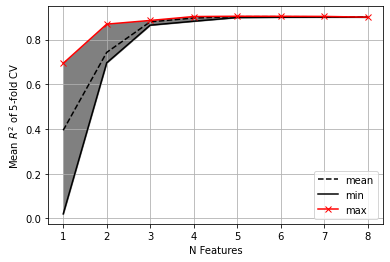

In [50]:
best_fewer_features_sr = seq_feature_importance(fewer_features_sr, train_feat_df_unscaled)
best_fewer_features_sr

In [51]:
# All fewer features
fewer_feat_sr_cv = svr_cv(train_feat_df_unscaled[fewer_features_sr], train_y, folds)
print(fewer_feat_sr_cv)
print(np.mean(fewer_feat_sr_cv))

[0.92264073 0.90718616 0.85896466 0.90075074 0.91017724]
0.8999439074881692


In [52]:
# Top 4 fewer features
top_fewer_feat_sr_cv = svr_cv(train_feat_df_unscaled[best_fewer_features_sr[0:4]], train_y, folds)
print(top_fewer_feat_sr_cv)
print(np.mean(top_fewer_feat_sr_cv))

[0.92517942 0.90649509 0.85636474 0.90723342 0.91817858]
0.9026902505218264


In [53]:
selected_feat_df = train_feat_df.copy()[selected_features_sr]
selected_feat_df.loc[:, "magnitude"] = train_y
corr = selected_feat_df.corr()
corr.style.background_gradient(cmap="coolwarm")

,amp_02.0,amp_04.0,amp_07.0,amp_10.0,amp_ratio_01.0,signal_dominant_amplitude,signal_variance,noise_variance,source_receiver_distance_logkm,noise_max_amplitude,receiver_back_azimuth,source_depth_km,signal_max_amplitude,magnitude
amp_02.0,1.000000,0.982107,0.962872,0.943431,0.494897,0.942617,0.958513,0.932282,-0.284690,0.924649,-0.167702,-0.100494,0.939641,0.843086
amp_04.0,0.982107,1.000000,0.977356,0.957397,0.476164,0.956462,0.971207,0.939087,-0.291953,0.931482,-0.158390,-0.097670,0.953536,0.840143
amp_07.0,0.962872,0.977356,1.000000,0.983742,0.470882,0.979525,0.988158,0.946141,-0.327393,0.939466,-0.164952,-0.096458,0.977632,0.821968
amp_10.0,0.943431,0.957397,0.983742,1.000000,0.468759,0.985189,0.994626,0.959900,-0.391456,0.955807,-0.195549,-0.138325,0.987715,0.784320
amp_ratio_01.0,0.494897,0.476164,0.470882,0.468759,1.000000,0.449648,0.468533,0.424565,-0.212464,0.425518,-0.103983,-0.151262,0.450598,0.349092
signal_dominant_amplitude,0.942617,0.956462,0.979525,0.985189,0.449648,1.000000,0.993253,0.948686,-0.383702,0.944721,-0.159169,-0.115334,0.996174,0.787606
signal_variance,0.958513,0.971207,0.988158,0.994626,0.468533,0.993253,1.000000,0.962537,-0.383815,0.958270,-0.175605,-0.127184,0.994690,0.798046
noise_variance,0.932282,0.939087,0.946141,0.959900,0.424565,0.948686,0.962537,1.000000,-0.394641,0.996661,-0.183999,-0.185528,0.952392,0.776586
source_receiver_distance_logkm,-0.284690,-0.291953,-0.327393,-0.391456,-0.212464,-0.383702,-0.383815,-0.394641,1.000000,-0.416889,0.429377,0.559877,-0.404690,0.111586
noise_max_amplitude,0.924649,0.931482,0.939466,0.955807,0.425518,0.944721,0.958270,0.996661,-0.416889,1.000000,-0.201930,-0.199760,0.949189,0.762637


## Add required starting features

['source_receiver_distance_logkm', 'receiver_back_azimuth', 'source_depth_km'] 0.10083265401003094
iteration 0
['source_receiver_distance_logkm', 'receiver_back_azimuth', 'source_depth_km']
amp_02.0 0.8817789048848239
amp_04.0 0.8873472764162316
amp_07.0 0.8911388117557675
amp_10.0 0.8796615071993624
amp_ratio_01.0 0.2692860384731851
signal_max_amplitude 0.8775307061073274
signal_variance 0.8937941307082221
noise_variance 0.857375321143406
noise_max_amplitude 0.8486685874057154
iteration 1
['source_receiver_distance_logkm', 'receiver_back_azimuth', 'source_depth_km', 'signal_variance']
amp_02.0 0.8983472045691474
amp_04.0 0.8974358881623736
amp_07.0 0.8939133059086307
amp_10.0 0.8913261348887914
amp_ratio_01.0 0.8875664191266195
signal_max_amplitude 0.8924336315468204
noise_variance 0.8923261164371082
noise_max_amplitude 0.891695823832707
iteration 2
['source_receiver_distance_logkm', 'receiver_back_azimuth', 'source_depth_km', 'signal_variance', 'amp_02.0']
amp_04.0 0.8989367571475946

['source_receiver_distance_logkm',
 'receiver_back_azimuth',
 'source_depth_km',
 'signal_variance',
 'amp_02.0',
 'noise_variance',
 'amp_04.0',
 'amp_10.0',
 'signal_max_amplitude',
 'amp_07.0',
 'noise_max_amplitude',
 'amp_ratio_01.0']

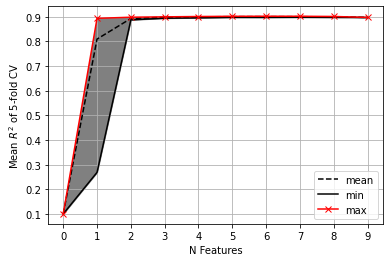

In [54]:
additional_features_sr = ['amp_02.0', 'amp_04.0', 'amp_07.0', 'amp_10.0', 'amp_ratio_01.0',
                       'signal_max_amplitude', 'signal_variance', 'noise_variance', 'noise_max_amplitude']
starting_features = ['source_receiver_distance_logkm','receiver_back_azimuth', 'source_depth_km']
best_features_with_start = seq_feature_importance(additional_features_sr, train_feat_df_unscaled,
                                                  starting_features=starting_features)
best_features_with_start

In [55]:
np.mean(svr_cv(train_feat_df_unscaled[best_features_with_start[0:4]], train_y, folds))

0.8937941307082221

In [56]:
np.mean(svr_cv(train_feat_df_unscaled[best_features_with_start[0:5]], train_y, folds))

0.8983472045691474

## Require starting features - linear model

['source_receiver_distance_logkm', 'sin_receiver_back_azimuth', 'source_depth_km'] 0.024260495368626022
iteration 0
['source_receiver_distance_logkm', 'sin_receiver_back_azimuth', 'source_depth_km']
amp_02.0 0.8463625153989284
amp_04.0 0.8471844157343563
amp_07.0 0.8407151896366697
amp_10.0 0.8237414339910234
amp_ratio_01.0 0.16813563317518893
signal_max_amplitude 0.8316537539773163
signal_dominant_frequency 0.09913754978932457
signal_variance 0.8472009825398397
noise_variance 0.8218420733629127
noise_max_amplitude 0.8150938128615829
signal_max_amplitude 0.8316537539773163
iteration 1
['source_receiver_distance_logkm', 'sin_receiver_back_azimuth', 'source_depth_km', 'signal_variance']
amp_02.0 0.8617618839910944
amp_04.0 0.8571193623561832
amp_07.0 0.8484526067327269
amp_10.0 0.8502712508495414
amp_ratio_01.0 0.8475805413628569
signal_max_amplitude 0.8481563267039002
signal_dominant_frequency 0.8544548651107071
noise_variance 0.8518665039155717
noise_max_amplitude 0.8511151054753652
si

['source_receiver_distance_logkm',
 'sin_receiver_back_azimuth',
 'source_depth_km',
 'signal_variance',
 'amp_02.0',
 'noise_variance',
 'signal_dominant_frequency',
 'amp_10.0',
 'amp_ratio_01.0',
 'amp_04.0',
 'signal_max_amplitude',
 'amp_07.0',
 'signal_max_amplitude',
 'noise_max_amplitude']

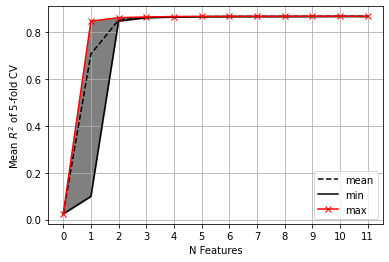

In [57]:
additional_features_sr = ['amp_02.0', 'amp_04.0', 'amp_07.0', 'amp_10.0', 'amp_ratio_01.0',
                       'signal_max_amplitude', 'signal_dominant_frequency', 'signal_variance', 
                          'noise_variance', 'noise_max_amplitude', 'signal_max_amplitude']
starting_features = ['source_receiver_distance_logkm','sin_receiver_back_azimuth', 'source_depth_km']
best_features_with_start_linear = seq_feature_importance(additional_features_sr, train_feat_df_unscaled,
                                                  starting_features=starting_features, kernel="linear")
best_features_with_start_linear

In [58]:
np.mean(svr_cv(train_feat_df_unscaled[best_features_with_start_linear[0:4]], train_y, folds, kernel='linear'))

0.8472009825398397

In [59]:
np.mean(svr_cv(train_feat_df_unscaled[best_features_with_start_linear[0:6]], train_y, folds, kernel="linear"))

0.8649271364355664

In [60]:
linear_features = ['source_receiver_distance_logkm',
 'sin_receiver_back_azimuth',
 'source_depth_km',
 'amp_02.0',
 'noise_max_amplitude',
 'signal_max_amplitude',
 'signal_variance',
 'noise_variance', 
 'amp_ratio_01.0']

np.mean(svr_cv(train_feat_df_unscaled[linear_features], train_y, folds, kernel='linear', epsilon=0.1))

0.8653635916203337

In [61]:
rbf_linear_features = ['source_receiver_distance_logkm',
 'receiver_back_azimuth',
 'source_depth_km',
 'amp_02.0',
 'noise_max_amplitude',
 'signal_max_amplitude',
 'signal_variance',
 'noise_variance', 
 'amp_ratio_01.0']

np.mean(svr_cv(train_feat_df_unscaled[rbf_linear_features], train_y, folds, epsilon=0.1))

0.9056456293272112

In [62]:
linear_feat_df = train_feat_df.copy()[linear_features]
linear_feat_df.loc[:, "magnitude"] = train_y
corr = linear_feat_df.corr()
corr.style.background_gradient(cmap="coolwarm")

,source_receiver_distance_logkm,sin_receiver_back_azimuth,source_depth_km,amp_02.0,noise_max_amplitude,signal_max_amplitude,signal_variance,noise_variance,amp_ratio_01.0,magnitude
source_receiver_distance_logkm,1.000000,-0.440076,0.559877,-0.284690,-0.416889,-0.404690,-0.383815,-0.394641,-0.212464,0.111586
sin_receiver_back_azimuth,-0.440076,1.000000,-0.437281,0.175916,0.203930,0.162398,0.178137,0.187164,0.139033,0.054510
source_depth_km,0.559877,-0.437281,1.000000,-0.100494,-0.199760,-0.123719,-0.127184,-0.185528,-0.151262,0.142842
amp_02.0,-0.284690,0.175916,-0.100494,1.000000,0.924649,0.939641,0.958513,0.932282,0.494897,0.843086
noise_max_amplitude,-0.416889,0.203930,-0.199760,0.924649,1.000000,0.949189,0.958270,0.996661,0.425518,0.762637
signal_max_amplitude,-0.404690,0.162398,-0.123719,0.939641,0.949189,1.000000,0.994690,0.952392,0.450598,0.776168
signal_variance,-0.383815,0.178137,-0.127184,0.958513,0.958270,0.994690,1.000000,0.962537,0.468533,0.798046
noise_variance,-0.394641,0.187164,-0.185528,0.932282,0.996661,0.952392,0.962537,1.000000,0.424565,0.776586
amp_ratio_01.0,-0.212464,0.139033,-0.151262,0.494897,0.425518,0.450598,0.468533,0.424565,1.000000,0.349092
magnitude,0.111586,0.054510,0.142842,0.843086,0.762637,0.776168,0.798046,0.776586,0.349092,1.000000


## Make predictions on test set

In [63]:
test_feat_matrix_unscaled = compute_feature_matrix(test_df, scaler=False)
test_feat_matrix_scaled = scaler.transform(test_feat_matrix_unscaled)
test_feat_df_scaled = pd.DataFrame(test_feat_matrix_scaled, columns=columns)
test_y = test_df.magnitude.values

test_feat_df_scaled.head()

,amp_ratio_01.0,amp_ratio_02.0,amp_ratio_03.0,amp_ratio_04.0,amp_ratio_05.0,amp_ratio_06.0,amp_ratio_07.0,amp_ratio_08.0,amp_ratio_09.0,amp_ratio_10.0,...,signal_dominant_frequency,signal_dominant_amplitude,noise_max_amplitude,signal_max_amplitude,signal_variance,noise_variance,source_receiver_distance_logkm,source_depth_km,sin_receiver_back_azimuth,receiver_back_azimuth
0,0.429735,-1.510186,-1.919820,-1.059134,0.114214,0.470919,0.444499,0.660550,0.921539,0.954278,...,-0.627929,1.413305,1.359454,1.248246,1.386518,1.533337,1.597219,0.617167,0.221118,-0.681962
1,0.369201,0.608823,1.389782,1.482987,1.131824,1.309649,1.614233,1.874121,1.950181,1.689448,...,0.791170,1.968597,1.817941,2.038781,1.961799,1.608501,-1.289033,-0.890544,3.450665,-3.181907
2,-1.423617,0.708308,0.894704,0.973731,0.107983,0.195110,0.454189,0.307101,0.052132,-0.204031,...,-0.266603,-0.059928,-0.403430,-0.022939,-0.133025,-0.325539,0.843583,0.169825,-0.475778,0.400116
3,-1.645737,-0.585427,-0.847766,-1.314085,-1.723063,-1.437131,-0.854572,-0.877351,-1.032270,-1.100470,...,0.791170,-1.476838,-1.007486,-1.392056,-1.355141,-1.022980,0.604651,-0.091125,-0.522211,0.203105
4,0.837594,1.116053,0.862135,0.242816,-0.187055,0.218071,0.373624,0.529864,0.712245,0.626327,...,-0.821540,-0.001957,-0.096850,-0.110208,0.068898,-0.071883,0.509514,0.654446,-0.204934,-0.369307


In [64]:
svr_linear = SVR(C=1.0, epsilon=0.1, kernel="linear")
svr_linear.fit(train_feat_df[linear_features], train_y)

y_est_linear = svr_linear.predict(test_feat_df_scaled[linear_features])
linear_test_r2 =r2_score(test_y, y_est_linear) 
print(linear_test_r2)
train_est_linear = svr_linear.predict(train_feat_df[linear_features]) 
print(r2_score(train_y, train_est_linear))

0.8782840414119668
0.8680710517690339


In [65]:
svr_rbf = SVR(C=1.0, epsilon=0.1, kernel="rbf")
svr_rbf.fit(train_feat_df[rbf_linear_features], train_y)

y_est_rbf = svr_rbf.predict(test_feat_df_scaled[rbf_linear_features])
rbf_test_r2 = r2_score(test_y, y_est_rbf)
print(rbf_test_r2)
train_est_rbf = svr_rbf.predict(train_feat_df[rbf_linear_features]) 
print(r2_score(train_y, train_est_rbf))

0.9051564186667438
0.9363181978462805


Text(0.5, 1.05, 'S Magnitudes - SVR Linear')

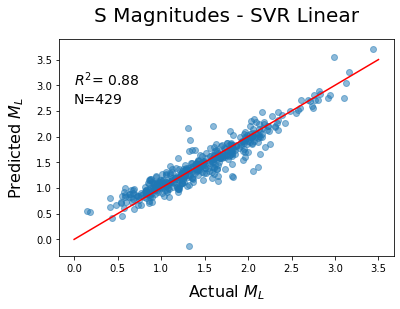

In [66]:
plt.scatter(test_y, y_est_linear, alpha=0.5)
plt.plot(np.arange(0, 4.0, 0.5), np.arange(0, 4.0, 0.5), color="red")
plt.xlabel(r"Actual $M_L$", fontsize=16, labelpad=10)
plt.ylabel(r"Predicted $M_L$", fontsize=16, labelpad=10)
plt.text(0, 3.0, f'{r"$R^2$="} {linear_test_r2:.02f}', fontsize=14)
plt.text(0, 2.65, f'N={test_feat_df_scaled.shape[0]}', fontsize=14)
plt.title("S Magnitudes - SVR Linear", fontsize=20, y=1.05)

Text(0.5, 1.05, '$M_L$ using S-arrival features')

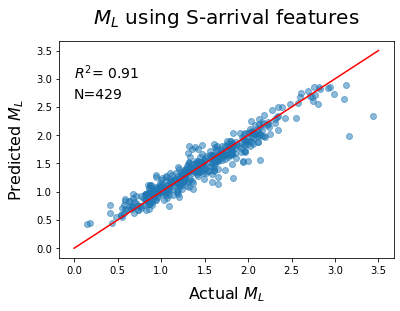

In [67]:
plt.scatter(test_y, y_est_rbf, alpha=0.5)
plt.plot(np.arange(0, 4.0, 0.5), np.arange(0, 4.0, 0.5), color="red")
plt.xlabel(r"Actual $M_L$", fontsize=16, labelpad=10)
plt.ylabel(r"Predicted $M_L$", fontsize=16, labelpad=10)
plt.text(0, 3.0, f'{r"$R^2$="} {rbf_test_r2:.02f}', fontsize=14)
plt.text(0, 2.65, f'N={test_feat_df_scaled.shape[0]}', fontsize=14)
plt.title(r"$M_L$ using S-arrival features", fontsize=20, y=1.05)

In [68]:
train_feat_df.shape

(1695, 34)

In [69]:
test_feat_df_scaled.shape

(429, 34)

In [90]:
train_feat_df.columns[no_sin_ba_feat_inds].tolist()

['amp_ratio_01.0',
 'amp_ratio_02.0',
 'amp_ratio_03.0',
 'amp_ratio_04.0',
 'amp_ratio_05.0',
 'amp_ratio_06.0',
 'amp_ratio_07.0',
 'amp_ratio_08.0',
 'amp_ratio_09.0',
 'amp_ratio_10.0',
 'amp_ratio_11.0',
 'amp_ratio_12.0',
 'amp_01.0',
 'amp_02.0',
 'amp_03.0',
 'amp_04.0',
 'amp_05.0',
 'amp_06.0',
 'amp_07.0',
 'amp_08.0',
 'amp_09.0',
 'amp_10.0',
 'amp_11.0',
 'amp_12.0',
 'signal_dominant_frequency',
 'signal_dominant_amplitude',
 'noise_max_amplitude',
 'signal_max_amplitude',
 'signal_variance',
 'noise_variance',
 'source_receiver_distance_logkm',
 'source_depth_km',
 'receiver_back_azimuth']

In [92]:
svr_rbf = SVR(C=1.0, epsilon=0.1, kernel="rbf")
svr_rbf.fit(train_feat_df[train_feat_df.columns[no_sin_ba_feat_inds].tolist()], train_y)

y_est_rbf = svr_rbf.predict(test_feat_df_scaled[train_feat_df.columns[no_sin_ba_feat_inds].tolist()])
rbf_test_r2 = r2_score(test_y, y_est_rbf)
print(rbf_test_r2)
train_est_rbf = svr_rbf.predict(train_feat_df[train_feat_df.columns[no_sin_ba_feat_inds].tolist()]) 
print(r2_score(train_y, train_est_rbf))

0.9095685269676427
0.9441474864894703


## Closer look at features with sr features

In [ ]:
def add_feat_to_base(base_features, additional_features, all_features_cv=None, top_features_cv=None):

    cv_means = []

    for cf in additional_features:
        feat_list = base_features.copy()
        feat_list.append(cf)
        cv_vals = svr_cv(train_feat_df_unscaled[feat_list], train_y, folds)
        cv_means.append(np.mean(cv_vals))

    plt.scatter(range(len(additional_features)), cv_means, marker="x")
    plt.xticks(range(len(additional_features)), labels=additional_features, rotation=45);
    if all_features_cv is not None:
        plt.axhline(np.mean(all_features_cv))
    if top_features_cv is not None:
        plt.axhline(np.mean(top_features_cv), color="C1")
    plt.show()
    
    return cv_means

In [ ]:
base_features = ['source_receiver_distance_logkm','source_depth_km', "receiver_back_azimuth"]

correlated_features = ['amp_02.0', 'amp_10.0', 
                     'noise_max_amplitude',
                     'amp_04.0',
                     'amp_07.0',
                     'noise_variance',
                     'signal_variance',
                     'signal_dominant_amplitude']

cv_means = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
                           top_features_cv=top_feat_sr_cv)

base_features = ['source_receiver_distance_logkm','source_depth_km', "receiver_back_azimuth", 'amp_02.0']

correlated_features = ['amp_10.0',
                     'noise_max_amplitude',
                     'amp_04.0',
                     'amp_07.0',
                     'noise_variance',
                     'signal_variance',
                     'signal_dominant_amplitude']

cv_means_amp02  = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
                           top_features_cv=top_feat_sr_cv)

base_features = ['source_receiver_distance_logkm', "receiver_back_azimuth", 'amp_02.0']

correlated_features = ['amp_10.0',
                     'noise_max_amplitude',
                     'amp_04.0',
                     'amp_07.0',
                     'noise_variance',
                     'signal_variance',
                     'signal_dominant_amplitude']

cv_means_nodepth = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
                           top_features_cv=top_feat_sr_cv)

base_features = ['source_receiver_distance_logkm', 'amp_02.0']

correlated_features = ['amp_10.0',
                     'noise_max_amplitude',
                     'amp_04.0',
                     'amp_07.0',
                     'noise_variance',
                     'signal_variance',
                     'signal_dominant_amplitude']


cv_means_nodepth_noba = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
                           top_features_cv=top_feat_sr_cv)

# SR distance is important 
# base_features = ["receiver_back_azimuth",'amp_ratio_01.0', "amp_01.0"]

# correlated_features = ['amp_02.0', "amp_08.0", "amp_12.0", "amp_18.0", "signal_variance", 
#                        "signal_dominant_amplitude", "signal_max_amplitude"]

# cv_means_nodepth_nosrd = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
#                            top_features_cv=top_feat_sr_cv)

In [ ]:
base_features = ['source_receiver_distance_logkm','source_depth_km', "receiver_back_azimuth"]

correlated_features = ['signal_variance', 'amp_02.0', 'amp_10.0', 
                     'noise_max_amplitude',
                     'amp_04.0',
                     'amp_07.0',
                     'noise_variance',
                     'signal_dominant_amplitude']

cv_means = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
                           top_features_cv=top_feat_sr_cv)

base_features = ['source_receiver_distance_logkm','source_depth_km', "receiver_back_azimuth", 'signal_variance']

correlated_features = ['amp_02.0', 'amp_10.0', 
                     'noise_max_amplitude',
                     'amp_04.0',
                     'amp_07.0',
                     'noise_variance',
                     'signal_dominant_amplitude']

cv_means_amp02  = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
                           top_features_cv=top_feat_sr_cv)

base_features = ['source_receiver_distance_logkm', "receiver_back_azimuth", 'signal_variance']

correlated_features = ['amp_02.0', 'amp_10.0', 
                     'noise_max_amplitude',
                     'amp_04.0',
                     'amp_07.0',
                     'noise_variance',
                     'signal_dominant_amplitude']


cv_means_nodepth = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
                           top_features_cv=top_feat_sr_cv)

base_features = ['source_receiver_distance_logkm', 'signal_variance']

correlated_features = ['amp_02.0', 'amp_10.0', 
                     'noise_max_amplitude',
                     'amp_04.0',
                     'amp_07.0',
                     'noise_variance',
                     'signal_dominant_amplitude']

cv_means_nodepth_noba = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
                           top_features_cv=top_feat_sr_cv)

# SR distance is important 
# base_features = ["receiver_back_azimuth",'amp_ratio_01.0', "amp_01.0"]

# correlated_features = ['amp_02.0', "amp_08.0", "amp_12.0", "amp_18.0", "signal_variance", 
#                        "signal_dominant_amplitude", "signal_max_amplitude"]

# cv_means_nodepth_nosrd = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
#                            top_features_cv=top_feat_sr_cv)

In [ ]:
correlated_features = ['amp_02.0', 'amp_10.0',
                     'noise_max_amplitude',
                     'amp_04.0',
                     'amp_07.0',
                     'noise_variance',
                     'signal_variance',
                     'signal_dominant_amplitude']

plt.scatter( range(0,len(correlated_features)), cv_means, marker="x", label="no_amp2.0")
plt.scatter( range(1,len(correlated_features)), cv_means_amp02, marker="o", label="yes_amp2.0")
plt.scatter( range(1,len(correlated_features)), cv_means_nodepth, marker="v", label="yes_amp2.0_no_depth")
plt.scatter( range(1,len(correlated_features)), cv_means_nodepth_noba, marker="x", label="yes_amp2.0_nodepth_noba")
# plt.scatter( range(1,len(correlated_features)), cv_means_nodepth_nosrd, marker="x", label="yes_amp1.0_nodepth_nosr")

plt.xticks(range(len(correlated_features)), labels=correlated_features, rotation=45);
plt.axhline(np.mean(selected_feat_sr_cv), label="all_selected_features")
plt.axhline(np.mean(top_feat_sr_cv), color="C1", label="top 5 features")
plt.legend();

In [ ]:
correlated_features = ['signal_variance', 'amp_02.0', 'amp_10.0', 
                     'noise_max_amplitude',
                     'amp_04.0',
                     'amp_07.0',
                     'noise_variance',
                     'signal_dominant_amplitude']

plt.scatter( range(0,len(correlated_features)), cv_means, marker="x", label="no_sv")
plt.scatter( range(1,len(correlated_features)), cv_means_amp02, marker="o", label="yes_sv")
plt.scatter( range(1,len(correlated_features)), cv_means_nodepth, marker="v", label="yes_sv_no_depth")
plt.scatter( range(1,len(correlated_features)), cv_means_nodepth_noba, marker="x", label="yes_sv_nodepth_noba")
# plt.scatter( range(1,len(correlated_features)), cv_means_nodepth_nosrd, marker="x", label="yes_amp1.0_nodepth_nosr")

plt.xticks(range(len(correlated_features)), labels=correlated_features, rotation=45);
plt.axhline(np.mean(selected_feat_sr_cv), label="all_selected_features")
plt.axhline(np.mean(top_feat_sr_cv), color="C1", label="top 5 features")
plt.legend();

In [ ]:
fewer_features_sr = ['source_receiver_distance_logkm', "receiver_back_azimuth", "source_depth_km",'amp_02.0', 
                          "amp_10.0", "signal_variance"]
fewer_feat_sr_df = train_feat_df.copy()[fewer_features_sr]
fewer_feat_sr_df.loc[:, "magnitude"] = train_y
corr = fewer_feat_sr_df.corr()
corr.style.background_gradient(cmap="coolwarm")

In [ ]:
fewer_feat_sr_cv = svr_cv(train_feat_df_unscaled[fewer_features_sr], train_y, folds)
print(fewer_feat_sr_cv)
print(np.mean(fewer_feat_sr_cv))

In [ ]:
fewest_features_sr = ['source_receiver_distance_logkm', "receiver_back_azimuth", "source_depth_km","signal_variance"]
fewest_feat_sr_df = train_feat_df.copy()[fewest_features_sr]
fewest_feat_sr_df.loc[:, "magnitude"] = train_y
corr = fewest_feat_sr_df.corr()
corr.style.background_gradient(cmap="coolwarm")

In [ ]:
fewest_feat_sr_cv = svr_cv(train_feat_df_unscaled[fewest_features_sr], train_y, folds)
print(fewest_feat_sr_cv)
print(np.mean(fewest_feat_sr_cv))

In [ ]:
linear_features_sr = ['source_receiver_distance_logkm', "sin_receiver_back_azimuth", "source_depth_km",
                      "signal_variance"]
                      #,'amp_02.0', "amp_10.0", "noise_variance"]

linear_feat_sr_cv = svr_cv(train_feat_df_unscaled[linear_features_sr], train_y, folds, kernel="linear")
print(linear_feat_sr_cv)
print(np.mean(linear_feat_sr_cv))

## Default C, gamma, and epsilon seem to work well for SVR with RBF

In [ ]:
#C_range = [1.0]#np.logspace(-2, 10, 5)
gamma_range = [7.4e-05, 0.1, 0.2, 0.3, 0.4, 5e-1, 1, "scale", "auto"]#np.logspace(-9, 3, 5)
epsilon_range = [5e-3, 1e-2, 5e-2, 1e-1, 2e-1]
param_grid = {"svr__gamma":gamma_range,  "svr__epsilon":epsilon_range} #"svr__C":C_range,
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', SVR(C=1.0))])
grid = GridSearchCV(pipeline, param_grid=param_grid, scoring="r2", n_jobs=3, cv=folds)
svr_cv_results = grid.fit(train_feat_df_unscaled[fewer_features_sr], train_y)

In [ ]:
scores = grid.cv_results_["mean_test_score"].reshape(len(epsilon_range), len(gamma_range))
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores,
    interpolation="nearest",
    cmap=plt.cm.viridis,
    #norm=MidpointNormalize(vmin=0.2, midpoint=0.92),
)
plt.xlabel("Gamma")
plt.ylabel("Epsilon")
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(epsilon_range)), epsilon_range)
plt.title("Validation accuracy")
plt.show()

## XGBoost

Try more hyperparameters, try with limited features

In [ ]:
from xgboost import XGBRegressor
from xgboost import DMatrix
import xgboost

In [ ]:
from sklearn.utils.fixes import loguniform
import scipy.stats as stats

In [ ]:
xgb = XGBRegressor(objective='reg:squarederror', eval_metric='rmse').fit(
                                    train_feat_matrix_unscaled[folds[0][0]], train_y[folds[0][0]])
xgb.score(train_feat_matrix_unscaled[folds[0][1]], train_y[folds[0][1]])

In [ ]:
train_feat_df.columns[43]

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 20))
xgboost.plot_importance(xgb, ax=ax)

In [ ]:
feat_bool = np.isin(train_feat_df.columns, fewer_features_sr)
xgb = XGBRegressor(objective='reg:squarederror', eval_metric='rmse').fit(
                                    train_feat_matrix_unscaled[folds[0][0]][:, feat_bool], train_y[folds[0][0]])
xgb.score(train_feat_matrix_unscaled[folds[0][1]][:, feat_bool], train_y[folds[0][1]])

In [ ]:
xgboost.plot_importance(xgb)

In [ ]:
feat_bool = np.isin(train_feat_df.columns, fewer_features_lat_lon)
xgb = XGBRegressor(objective='reg:squarederror', eval_metric='rmse').fit(
                                    train_feat_matrix_unscaled[folds[0][0]][:, feat_bool], train_y[folds[0][0]])
xgb.score(train_feat_matrix_unscaled[folds[0][1]][:, feat_bool], train_y[folds[0][1]])

In [ ]:
xgboost.plot_importance(xgb)

In [ ]:
grid_params = {'max_depth': [1, 2, 3, 5, 10], 
          'eta': [0.05, 0.1, 0.2, 0.3, 0.5],
          'gamma': [0, 0.2, 0.5, 1, 1.5, 2, 5], 
         'min_child_weight':[0, 0.5, 1, 2], 
         'max_delta_step': [0, 1, 2], 
          'subsample': [0.5, 1]}

params = {'max_depth': stats.randint(3, 18),
          'gamma': stats.uniform(0, 5),
          'learning_rate': loguniform(1e-2, 1e0),
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree':stats.uniform(0.5,1),
          'min_child_weight':stats.randint(0, 10), 
          'n_estimators': [100, 250, 500, 750],
          }
    
# params = {'objective': 'reg:squarederror'}
# params['eval_metric'] = 'rmse'
# params['nthread'] = 2

In [ ]:
xgb = XGBRegressor(objective='reg:squarederror', eval_metric='rmse') #, topnthread=2
# grid_search = GridSearchCV(xgb, param_grid=grid_params, scoring="r2", 
#                            n_jobs=3, cv=folds).fit(train_feat_matrix_unscaled, train_y)
rand_search = RandomizedSearchCV(xgb, param_distributions=params, scoring="r2", 
                           n_jobs=3, cv=folds).fit(train_feat_matrix_unscaled[:, feat_bool], train_y)

In [ ]:
rand_search.best_estimator_

In [ ]:
# {'eta': 0.1,
#  'gamma': 0.5,
#  'max_delta_step': 1,
#  'max_depth': 5,
#  'min_child_weight': 0.5}

# 0.8620877350386309

In [ ]:
rand_search.best_params_

In [ ]:
rand_search.best_score_

In [ ]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df.sort_values("rank_test_score")

In [ ]:
num_round = 100
dtrain = DMatrix(train_feat_matrix_unscaled, label=train_y, feature_names=train_feat_df_unscaled.columns)
bst_cv = xgboost.cv(param, dtrain, num_round, folds=folds, early_stopping_rounds=3, 
               callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)])

In [ ]:
x_ticks = range(1, len(bst_cv)+1)
plt.plot(x_ticks, bst_cv["train-rmse-mean"], color="k")
plt.plot(x_ticks, bst_cv["train-rmse-mean"]+bst_cv["train-rmse-std"], linestyle="--", color="C0")
plt.plot(x_ticks, bst_cv["train-rmse-mean"]-bst_cv["train-rmse-std"], linestyle="--", color="C0")
plt.fill_between(x_ticks,bst_cv["train-rmse-mean"]+bst_cv["train-rmse-std"], 
                 bst_cv["train-rmse-mean"]-bst_cv["train-rmse-std"], color="C0", alpha=0.5, label="train")

plt.plot(x_ticks, bst_cv["test-rmse-mean"], color="k")
plt.plot(x_ticks, bst_cv["test-rmse-mean"]+bst_cv["test-rmse-std"], linestyle="--", color="C1")
plt.plot(x_ticks, bst_cv["test-rmse-mean"]-bst_cv["test-rmse-std"], linestyle="--", color="C1")
plt.fill_between(x_ticks, bst_cv["test-rmse-mean"]+bst_cv["test-rmse-std"], 
                 bst_cv["test-rmse-mean"]-bst_cv["test-rmse-std"], color="C1", alpha=0.5, label="test")

plt.ylabel("RMSE")
plt.xlabel("Iteration")

#plt.xticks(x_ticks)
plt.legend()